# Recommender Systems with Python

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

Let's get started!

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

## Get the Data

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [3]:
df.head()

user_id  item_id  rating  timestamp
0        0       50       5  881250949
1        0      172       5  881250949
2        0      133       1  881250949
3      196      242       3  881250949
4      186      302       3  891717742

Now let's get the movie titles:

In [4]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

item_id              title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)

We can merge them together:

In [5]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

user_id  item_id  rating  timestamp             title
0        0       50       5  881250949  Star Wars (1977)
1      290       50       5  880473582  Star Wars (1977)
2       79       50       4  891271545  Star Wars (1977)
3        2       50       5  888552084  Star Wars (1977)
4        8       50       5  879362124  Star Wars (1977)

# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

C:\Users\Pavilion\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's create a ratings dataframe with average rating and number of ratings:

In [7]:
df.groupby('title')['rating'].mean().sort_values(ascending=False)

title
Marlene Dietrich: Shadow and Light (1996)       5.0
Prefontaine (1997)                              5.0
Santa with Muscles (1996)                       5.0
Star Kid (1997)                                 5.0
Someone Else's America (1995)                   5.0
                                               ... 
Touki Bouki (Journey of the Hyena) (1973)       1.0
JLG/JLG - autoportrait de décembre (1994)       1.0
Daens (1992)                                    1.0
Butterfly Kiss (1995)                           1.0
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
Name: rating, Length: 1664, dtype: float64

In [8]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

In [9]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

rating
title                              
'Til There Was You (1997)  2.333333
1-900 (1994)               2.600000
101 Dalmatians (1996)      2.908257
12 Angry Men (1957)        4.344000
187 (1997)                 3.024390

Now set the number of ratings column:

In [10]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings

rating  num of ratings
title                                                          
'Til There Was You (1997)              2.333333               9
1-900 (1994)                           2.600000               5
101 Dalmatians (1996)                  2.908257             109
12 Angry Men (1957)                    4.344000             125
187 (1997)                             3.024390              41
...                                         ...             ...
Young Guns II (1990)                   2.772727              44
Young Poisoner's Handbook, The (1995)  3.341463              41
Zeus and Roxanne (1997)                2.166667               6
unknown                                3.444444               9
Á köldum klaka (Cold Fever) (1994)     3.000000               1

[1664 rows x 2 columns]

Now a few histograms:

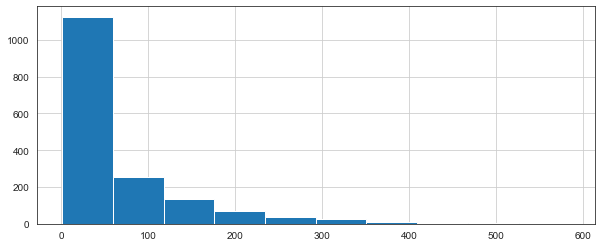

In [11]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=10)

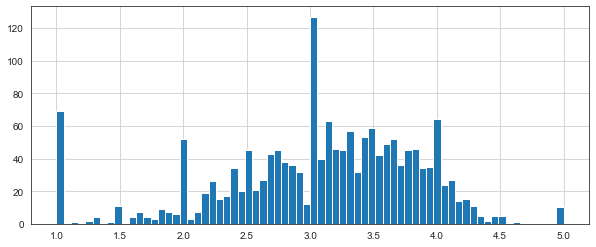

In [12]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

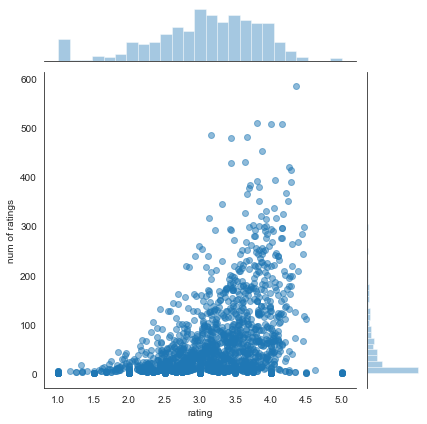

In [13]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

In [14]:
ratings[(ratings['num of ratings'] < 5) & (ratings['rating']> 4)]

rating  num of ratings
title                                                                      
Aiqing wansui (1994)                               5.000000               1
Anna (1996)                                        4.500000               2
Bitter Sugar (Azucar Amargo) (1996)                4.333333               3
Crossfire (1947)                                   4.250000               4
Entertaining Angels: The Dorothy Day Story (1996)  5.000000               1
Everest (1998)                                     4.500000               2
Great Day in Harlem, A (1994)                      5.000000               1
Innocents, The (1961)                              4.250000               4
Letter From Death Row, A (1998)                    4.333333               3
Marlene Dietrich: Shadow and Light (1996)          5.000000               1
Maya Lin: A Strong Clear Vision (1994)             4.500000               4
Prefontaine (1997)                                 5.000000               3
Saint of Fort Washington, The (1993)               5.000000               2
Santa with Muscles (1996)                          5.000000               2
Some Mother's Son (1996)                           4.500000               2
Someone Else's America (1995)                      5.000000               1
Star Kid (1997)                                    5.000000               3
They Made Me a Criminal (1939)                     5.000000               1

Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [15]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title    'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                   
0                              NaN           NaN                    NaN   
1                              NaN           NaN                    2.0   
2                              NaN           NaN                    NaN   
3                              NaN           NaN                    NaN   
4                              NaN           NaN                    NaN   

title    12 Angry Men (1957)  187 (1997)  2 Days in the Valley (1996)  \
user_id                                                                 
0                        NaN         NaN                          NaN   
1                        5.0         NaN                          NaN   
2                        NaN         NaN                          NaN   
3                        NaN         2.0                          NaN   
4                        NaN         NaN                          NaN   

title    20,000 Leagues Under the Sea (1954)  2001: A Space Odyssey (1968)  \
user_id                                                                      
0                                        NaN                           NaN   
1                                        3.0                           4.0   
2                                        NaN                           NaN   
3                                        NaN                           NaN   
4                                        NaN                           NaN   

title    3 Ninjas: High Noon At Mega Mountain (1998)  39 Steps, The (1935)  \
user_id                                                                      
0                                                NaN                   NaN   
1                                                NaN                   NaN   
2                                                1.0                   NaN   
3                                                NaN                   NaN   
4                                                NaN                   NaN   

title    ...  Yankee Zulu (1994)  Year of the Horse (1997)  \
user_id  ...                                                 
0        ...                 NaN                       NaN   
1        ...                 NaN                       NaN   
2        ...                 NaN                       NaN   
3        ...                 NaN                       NaN   
4        ...                 NaN                       NaN   

title    You So Crazy (1994)  Young Frankenstein (1974)  Young Guns (1988)  \
user_id                                                                      
0                        NaN                        NaN                NaN   
1                        NaN                        5.0                3.0   
2                        NaN                        NaN                NaN   
3                        NaN                        NaN                NaN   
4                        NaN                        NaN                NaN   

title    Young Guns II (1990)  Young Poisoner's Handbook, The (1995)  \
user_id                                                                
0                         NaN                                    NaN   
1                         NaN                                    NaN   
2                         NaN                                    NaN   
3                         NaN                                    NaN   
4                         NaN                                    NaN   

title    Zeus and Roxanne (1997)  unknown  Á köldum klaka (Cold Fever) (1994)  
user_id                                                                        
0                            NaN      NaN                                 NaN  
1                            NaN      4.0                                 NaN  
2                            NaN      NaN                    

Most rated movie:

In [16]:
ratings.sort_values('num of ratings',ascending=False).head(10)

rating  num of ratings
title                                                  
Star Wars (1977)               4.359589             584
Contact (1997)                 3.803536             509
Fargo (1996)                   4.155512             508
Return of the Jedi (1983)      4.007890             507
Liar Liar (1997)               3.156701             485
English Patient, The (1996)    3.656965             481
Scream (1996)                  3.441423             478
Toy Story (1995)               3.878319             452
Air Force One (1997)           3.631090             431
Independence Day (ID4) (1996)  3.438228             429

Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

In [17]:
ratings.head()

rating  num of ratings
title                                              
'Til There Was You (1997)  2.333333               9
1-900 (1994)               2.600000               5
101 Dalmatians (1996)      2.908257             109
12 Angry Men (1957)        4.344000             125
187 (1997)                 3.024390              41

Now let's grab the user ratings for those two movies:

In [18]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [19]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

C:\Users\Pavilion\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Pavilion\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [20]:
similar_to_starwars

title
'Til There Was You (1997)                0.872872
1-900 (1994)                            -0.645497
101 Dalmatians (1996)                    0.211132
12 Angry Men (1957)                      0.184289
187 (1997)                               0.027398
                                           ...   
Young Guns II (1990)                     0.228615
Young Poisoner's Handbook, The (1995)   -0.007374
Zeus and Roxanne (1997)                  0.818182
unknown                                  0.723123
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [21]:
contoh = pd.DataFrame({'a': [3,3, np.nan, 5], 'b':[4,3,4,2], 'c':[7,5,3,7]})
contoh.head()

a  b  c
0  3.0  4  7
1  3.0  3  5
2  NaN  4  3
3  5.0  2  7

In [22]:
contoh.corrwith(contoh['b'])

a   -0.866025
b    1.000000
c   -0.454545
dtype: float64

In [23]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

Correlation
title                                 
'Til There Was You (1997)     0.872872
1-900 (1994)                 -0.645497
101 Dalmatians (1996)         0.211132
12 Angry Men (1957)           0.184289
187 (1997)                    0.027398

Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [24]:
corr_starwars.sort_values('Correlation',ascending=False)

Correlation
title                                  
Commandments (1997)                 1.0
Cosi (1996)                         1.0
No Escape (1994)                    1.0
Stripes (1981)                      1.0
Man of the Year (1995)              1.0
...                                 ...
For Ever Mozart (1996)             -1.0
Frankie Starlight (1995)           -1.0
I Like It Like That (1994)         -1.0
American Dream (1990)              -1.0
Theodore Rex (1995)                -1.0

[1410 rows x 1 columns]

In [25]:
df[df['title'] == 'Commandments (1997)']

user_id  item_id  rating  timestamp                title
99193      345     1096       3  884994682  Commandments (1997)
99194       57     1096       3  883697940  Commandments (1997)
99195      782     1096       2  891499699  Commandments (1997)

In [26]:
df[(df['title'] == 'Star Wars (1977)') & ((df['user_id'] ==345)| (df['user_id'] == 57)| (df['user_id'] == 782))]

user_id  item_id  rating  timestamp             title
196      345       50       5  884992367  Star Wars (1977)
447       57       50       5  883697105  Star Wars (1977)
567      782       50       3  891499243  Star Wars (1977)

In [27]:
df[df['title'] == 'Good Man in Africa, A (1994)']

user_id  item_id  rating  timestamp                         title
99189      378     1523       2  880334067  Good Man in Africa, A (1994)
99190      325     1523       4  891478504  Good Man in Africa, A (1994)

In [28]:
df[(df['title'] == 'Star Wars (1977)') & ((df['user_id'] ==325)| (df['user_id'] == 378))]

user_id  item_id  rating  timestamp             title
89       378       50       4  880045145  Star Wars (1977)
135      325       50       5  891478140  Star Wars (1977)

Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [29]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

Correlation  num of ratings
title                                                 
'Til There Was You (1997)     0.872872               9
1-900 (1994)                 -0.645497               5
101 Dalmatians (1996)         0.211132             109
12 Angry Men (1957)           0.184289             125
187 (1997)                    0.027398              41

Now sort the values and notice how the titles make a lot more sense:

In [30]:
corr_starwars[corr_starwars['num of ratings']>=100].sort_values('Correlation',ascending=False).head()

Correlation  \
title                                                             
Star Wars (1977)                                       1.000000   
Empire Strikes Back, The (1980)                        0.748353   
Return of the Jedi (1983)                              0.672556   
Raiders of the Lost Ark (1981)                         0.536117   
Austin Powers: International Man of Mystery (1997)     0.377433   

                                                    num of ratings  
title                                                               
Star Wars (1977)                                               584  
Empire Strikes Back, The (1980)                                368  
Return of the Jedi (1983)                                      507  
Raiders of the Lost Ark (1981)                                 420  
Austin Powers: International Man of Mystery (1997)             130

Now the same for the comedy Liar Liar:

In [31]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

Correlation  num of ratings
title                                             
Liar Liar (1997)          1.000000             485
Batman Forever (1995)     0.516968             114
Mask, The (1994)          0.484650             129
Down Periscope (1996)     0.472681             101
Con Air (1997)            0.469828             137

In [32]:
corr_liarliar[corr_liarliar['num of ratings']>=100].sort_values('Correlation',ascending=False).head(10)

Correlation  num of ratings
title                                                                 
Liar Liar (1997)                              1.000000             485
Batman Forever (1995)                         0.516968             114
Mask, The (1994)                              0.484650             129
Down Periscope (1996)                         0.472681             101
Con Air (1997)                                0.469828             137
Pretty Woman (1990)                           0.469790             164
101 Dalmatians (1996)                         0.469765             109
Michael (1996)                                0.442022             119
Waterworld (1995)                             0.438405             102
Indiana Jones and the Last Crusade (1989)     0.414427             331

In [33]:
corr_starwars = corr_starwars.join(ratings['rating'])
corr_starwars.head()

Correlation  num of ratings    rating
title                                                           
'Til There Was You (1997)     0.872872               9  2.333333
1-900 (1994)                 -0.645497               5  2.600000
101 Dalmatians (1996)         0.211132             109  2.908257
12 Angry Men (1957)           0.184289             125  4.344000
187 (1997)                    0.027398              41  3.024390

In [34]:
corr_starwars[(corr_starwars['num of ratings']>100) & (corr_starwars['rating'] > 3)].sort_values('Correlation', ascending = False).head()

Correlation  \
title                                                             
Star Wars (1977)                                       1.000000   
Empire Strikes Back, The (1980)                        0.748353   
Return of the Jedi (1983)                              0.672556   
Raiders of the Lost Ark (1981)                         0.536117   
Austin Powers: International Man of Mystery (1997)     0.377433   

                                                    num of ratings    rating  
title                                                                         
Star Wars (1977)                                               584  4.359589  
Empire Strikes Back, The (1980)                                368  4.206522  
Return of the Jedi (1983)                                      507  4.007890  
Raiders of the Lost Ark (1981)                                 420  4.252381  
Austin Powers: International Man of Mystery (1997)             130  3.246154

In [35]:
corr_starwars[(corr_starwars['num of ratings']>100) & (corr_starwars['rating'] > 4)].sort_values('Correlation', ascending = False).head()

Correlation  num of ratings    rating
title                                                                 
Star Wars (1977)                    1.000000             584  4.359589
Empire Strikes Back, The (1980)     0.748353             368  4.206522
Return of the Jedi (1983)           0.672556             507  4.007890
Raiders of the Lost Ark (1981)      0.536117             420  4.252381
Sting, The (1973)                   0.367538             241  4.058091